In this interactive notebook, we will go through examples of different types of classification models, all using the MNIST dataset.

<h1>Binary Classification</h1>

Part 1 of our exploration-by-project into classification is the easiest. Think of Jian Yangs Hotdog/Not Hotdog!

In [1]:
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

mnist = fetch_openml('mnist_784', as_frame=False)


fetch_openml() returns a sklearn.utils.Bunch object. This is a dictionary whose entries can also be accessed as attributes. It contains the following entries:

* "DESCR" - a description of the data
* "data" - the input data - a 2d numpy array (usually)
* "target" - the labels, usually a 1d numpy array

Usually fetch returns a pandas dataframe, but since our data is images pandas isnt ideal, so we set as frame to false.

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

70,000 images with 784 "features (columns)". This is because each image is 28*28 pixels (784) and each feature represents one pixel's intensity (from 0-255)

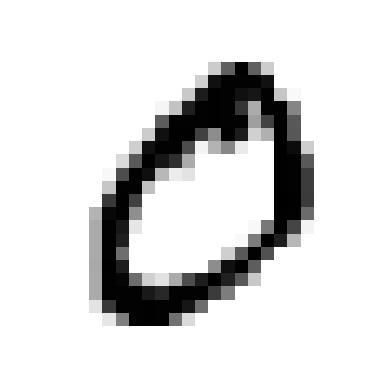

In [4]:
import matplotlib.pyplot as plt


def plot_digit(image_data): #img data is a single row of our X array
    image = image_data.reshape(28,28) # reshape the array from 1row-784 columns to 28 rows 28 columns - same as og image dimensions
    plt.imshow(image, cmap='binary') #show the image and each pixel is either "on" or "off"
    plt.axis('off') #turn off axes

plot_digit(X[1])
plt.show()

<h1>The train test split</h1>
We can very simply create a train test split for this project because the data is already shuffled for us. 

Many ML algos are sensitive to the order of the training instances - if they get too many similar instances in a row, they will perform like ass. Shuffling data will help alleviate this.

Shuffling is a bad idea for time-series data.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)



Our binary classifier will solve  a simple problem : is a digit a 5?

Step 1: Let's create the target vectors.

In [6]:
y_train_5 = y_train=='5' #this is a vector that is false for every outcome except 5!
y_test_5 = y_test == '5'



<h1>The Problems With Accuracy Scoring</h1>

To illustrate how accuracy scoring is not always the best, lets try training a classifier. For our example, we'll use an SGD (Stochastic gradient descent) classifier.



In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train_5)



SGDClassifier(random_state=42)

To use this classifier, we can pass in:

`sgd_clf.predict([some_digit])` -> digit must be an array-like object, so you can't just pass (somedigit), it has to be ([some_digit])

Let's measure our performance.

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5,
                cv=3, scoring='accuracy')


array([0.96392478, 0.95842129, 0.96117188])

WOOP WOOP! You got >95% accuracy on all cross val folds! Wtf??! FIRST TRY!

Hold your horses. Now, lets take a look at a dummy classifier that just classifies every image as the most frequent class
* in our case, the most frequent class is "false", because we are a binary classifier, and only 10% of outcomes are actually 5's (true).


In [9]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91032365, 0.91031792, 0.91031792])

BRUH MOMENT. Just classifing every single image as "not 5" gives us 91% accuracy. Again, this is because roughly 10% of the data is 5's, so 90% is not 5.

This demonstrates the DANGER of using accuracy-based metrics on skewed datasets (when some classes are more frequent than others). 

A much better way is to evaluate the performance of a classifier with a confusion matrix.

<h1>Confusion Matrices</h1>
A confusion matrix counts the number of times class A is classified as class B, for all possible pairs.

For example, it will tell us the number of times the classifier confused an 8 with a 0 --> just look at row #8 column #0.

to do this, we make predictions and compare them to the actual targets. We don't want to use the test set (only use test set at the end of the project!), we can use SKLearn's **crossvalpredict** function.


In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Cross val predict performs K-fold cross validation, but instead of returning evaluation scores (like cross val scores), it returns the predictions made by the model on each fold.

It returns all of these folds results as a single array. 

Lets get a confusion matrix. we can import it directly from sklearn:

In [11]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_train_5, y_train_pred)
cm

array([[41582,  1112],
       [  709,  3497]], dtype=int64)

* Each row represents a class. In our case, we have **non-5** and **5s**.

* Each column represents an outcome.

For example, the first row represents all non-5s. The first column says that 41,582 were correctly classified as non-5. The second column says 1112 were wrongly classified as 5 (false positive, type I error).

The second row is all 5s. 709 were wrongly classified as non-5 (false negative, type II error), and 3497 were classified as 5 (true positive).

<table>
        <tr>
                <th></th>
                <th>Non-5 Prediction</th>
                <th>5 Prediction</th>
        </tr>
        <tr>
                <th>Non-5 True Value</th>
                <th>41582</th>
                <th>1112</th>
        </tr>
        <tr>
                <th>5 true value</th>
                <th>709</th>
                <th>3497</th>
        </tr>
</table>


<h3>Model Measuring Metrics</h3>

**Precision: Measuring the accuracy of positive predictions**
$$P = {TruePositives \over TruePositives + FalsePositives}$$

 

Precision is usually used along with another metric called Recall. This is because precision itself is somewhat easy to pad. For example:

`Imagine a model that always makes negative predictions, except for one where it is absolutely 100% positive about. This model would have 0 false positives and 1 true positive, a perfect precision socre of 1/1. However, this model is not very useful in the real world`

**Recall - The True Positive Rate TPR**
$$R = {TruePositives\over TruePositives + FalseNegatives}$$

Looking back at our table...
<table>
        <tr>
                <th></th>
                <th>Non-5 Prediction</th>
                <th>5 Prediction</th>
        </tr>
        <tr>
                <th>Non-5 True Value</th>
                <th>41582 TRUE NEGATIVES</th>
                <th>1112 FALSE POSITIVES</th>
        </tr>
        <tr>
                <th>5 true value</th>
                <th>709 FALSE NEGATIVES</th>
                <th>3497 TRUE POSITIVES</th>
        </tr>
</table>

<h4>Whats important? Precision vs Recall</h4>

It really depends on your situation. Say you trained a classifier to detect videos safe for kids. Would you:
1. Want a classifier that classifies many safe videos as unsafe, but keeps only the safest videos? (HIGH PRECISION, not alot of false positives.)
OR
2. Want a classifier that classifies many unsafe videos as safe (HIGH RECALL, not alot of false negatives.)

Obviously most people would want model number 1.

What about another situation: Stopping shoplifters. Would you:
1. Want a model that only catches people it is 100% sure are shoplifting? (HIGH PRECISION, low false positives)
OR
2. Want a model that assumes more people are shoplifting, even though they might be innocent (HIGH RECALL, low false negatives)

Most store owners would probably want a model more like number 2.

<h3>The F1 Score</h3>

The F1 Score is the *harmonic mean* of precision and recall -> it combines them into a single metric. 
$$F_1 = {TruePositives \over TruePositives + {FalseNeg + FalsePos \over 2}}$$

The F1 Score is high only if **both precision and recall are high**. Sometimes this is what you want, other times, as discussed above, you want to favor one over the other. It is up to your intuition.

<h3>Using SKLearn to calculate these metrics</h3>

SKLearn has many prebuilt functions that allow us to calculate F1, Precision, and Recall very quickly. Lets go over them below:

In [12]:
#precision and recall
from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_train_5, y_train_pred)
rec = recall_score(y_train_5, y_train_pred)

prec, rec

(0.7587329138641787, 0.8314312886352829)

This means our model is correct about 75% of the time (prec = truepos/(truepos + falsepos))

It also means that our model is correctly predicting about 83% of all 5s (recall = truepos/(truepos+falseneg))

Now lets do F1 score:

In [13]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)

f1

0.7934203062960862

Honestly, it might not be the best, but our model isn't too shabby.

<h2>The Precision/Recall TradeOff</h2>
We know from our examples earlier (kid friendly videos + shoplifting) that you can't really have it both ways. 

Increasing precision reduces recall, and increating recall reduces precision.

To understand this tradeoff, we will take a look at *how* SGDClassifier makes its decisions.
* For each instance, SGD computes a score based on a **decision function**
    * If the score is greater than a threshold, it assigns the instance to the positive class, otherwise the negative class.

In the figure below, assume that the decision threshold is at one of the arrows. We will calculate precision and recall for each of the decision thresholds. Notice how precision and recall are negatively correllated. 

<img src="./img/Decision Threshold.png">

Desafortunadamente, SKLearn does not let you set the threshold directly. However, it does give you access to view the decision scores it makes.

To do this, instead of calling `.predict()`, we can call `.decision_function()`. 

This will return a score for each instance instead of an actual prediction. We can then use this to test any threshold we want.

In [14]:
y_scores = sgd_clf.decision_function(X_train)
threshold = -200
custom_thresh_pred = y_scores > threshold
custom_thresh_pred

array([ True, False, False, ..., False, False, False])

In [15]:
custom_thresh_pred_p = precision_score(y_train_5, custom_thresh_pred)
custom_thresh_pred_p

0.8388110198163364